# Aprendizaje profundo para detección de sexismo
- Óscar Alvarado
- Dante Bermúdez

## Índice

## Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string

import re
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer

from itertools import islice as take
import torch
from torch import nn
# !pip install torchinfo
from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

# barras de progreso
from tqdm import trange

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

/home/oscar/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554793803/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

## Preprocesamiento

In [3]:
def colapsar_repeticion(match):
    elemento = match.groups()
    assert len(match.groups()) == 1
    return elemento[0]

def procesar_tweet(tweet):
    tweet = tweet.lower()
    regex_usuario = re.compile(r"@[\w\d]+")
    tweet = regex_usuario.sub("@usuario", tweet)
    
    regex_link = re.compile(r"\b(?:https?://|www\.)\S+\b")
    tweet = regex_link.sub("<link>", tweet)
    
    regex_frac = re.compile(r"\d+/\d+\w*")
    tweet = regex_frac.sub("<número>", tweet)
    
    regex_numbers = re.compile(r"\d+\w*")
    tweet = regex_numbers.sub("<número>", tweet)
    
    tokenizer = TweetTokenizer(reduce_len=True)
    tokens = tokenizer.tokenize(tweet)
    
    regex_collapse = re.compile(r"(\w)\1{2}")
    
    tokens = [regex_collapse.sub(colapsar_repeticion, token) for token in tokens]
    
    simbolos = r"""'@¡"#$%&'()*+,-./:;<=>¿[\]^_`{|}~'"""
    simbolos = set(simbolos) | set(["--->", "...", ". . .", ". .", ". ...", ".."])
    tokens = [token for token in tokens if token not in simbolos]
    
    return tokens

In [4]:
def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [5]:
df_train = pd.read_csv("../datos/training/EXIST2021_training.tsv", sep="\t")
df_train.head()

,test_case,id,source,language,text,task1,task2
0,EXIST2021,1,twitter,en,"She calls herself ""anti-feminazi"" how about sh...",sexist,ideological-inequality
1,EXIST2021,2,twitter,en,"Now, back to these women, the brave and the be...",non-sexist,non-sexist
2,EXIST2021,3,twitter,en,"@CurvyBandida @Xalynne_B Wow, your skirt is ve...",sexist,objectification
3,EXIST2021,4,twitter,en,@AurelieGuiboud Incredible! Beautiful!But I l...,non-sexist,non-sexist
4,EXIST2021,5,twitter,en,i find it extremely hard to believe that kelly...,non-sexist,non-sexist


In [6]:
tweets = df_train["text"].apply(procesar_tweet)
labels1 = df_train["task1"].map({"sexist":1, "non-sexist":0}).values

[Volver al índice](#Índice)

## Train - test

In [7]:
train_tweets, test_tweets, train_labels, test_labels = train_test_split(tweets, labels1, test_size=0.2,
                                                                       random_state = 42)

In [8]:
vect = CountVectorizer(min_df=2, tokenizer=lambda x:x, preprocessor=lambda x:x)
vect.fit_transform(train_tweets)

<5581x8293 sparse matrix of type '<class 'numpy.int64'>'
	with 127143 stored elements in Compressed Sparse Row format>

In [9]:
word2idx = {word: idx for idx, word in enumerate(vect.get_feature_names(), 2)}
word2idx["<PAD>"] = 0
word2idx["<START>"] = 1
X_train = [[word2idx.get(word, 1) for word in tweet] for tweet in train_tweets]
print(X_train[0])

[249, 249, 249, 8192, 7293, 2802, 1, 4928, 2, 2, 8214, 5160, 1, 5008, 850, 6535, 6138, 2690, 7697, 1, 7293, 2802, 5464, 8192, 5103, 7293, 4415, 7994, 250, 1, 4769, 6935, 4415, 6138, 3446, 2545, 3028, 8192, 4415, 6138, 5103, 6138, 6622, 7293, 1986, 4971, 988, 5616, 6935, 4760, 7319, 1934]


In [10]:
X_test = [[word2idx.get(word, 1) for word in tweet] for tweet in test_tweets]
print(X_test[0])

[249, 249, 5103, 2697, 6138, 5103, 2034, 5083, 7697, 2697, 6138, 2697, 5336, 1, 3103, 2034, 7238, 4541, 1591, 7481, 4225, 4946, 6138, 3518, 2604, 2545, 3320, 8192, 2296, 4541, 5103, 5814, 7328, 5008, 2604, 1749, 2034, 4191, 4945, 1, 4978, 6823, 5103, 5814, 1, 250, 6021, 8192, 3458, 2031, 1591, 4191, 1]


In [11]:
max_len = max([len(X) for X in X_train])
max_len

102

In [12]:
# Palabras en el vocabulario
len(word2idx)

8295

In [13]:
# Padding
for idx, X in enumerate(X_train):
    zeros = [0 for _ in range(max_len)]
    len_x = len(X)
    zeros[-len_x:] = X
    X_train[idx] = zeros
    
for idx, X in enumerate(X_test):
    zeros = [0 for _ in range(max_len)]
    len_x = len(X)
    zeros[-len_x:] = X
    X_test[idx] = zeros

[Volver al índice](#Índice)

## Arquitectura básica

In [15]:
# Definición de arquitectura
class CNN(nn.Module):    
    def __init__(self, num_labels=2, num_embeddings = len(word2idx), embedding_dim = max_len,
        kernels = 300, k_cnn = 9, pad_cnn = 0, dilation_cnn = 1, step_cnn = 1, k_pool = 1,
        pad_pool = 0, dilation_pool = 1, step_pool = 1):
        super(CNN, self).__init__()
        
        
        # Capa para Embeddings
        self.emb = nn.Embedding(num_embeddings, embedding_dim)
        
        # Capa convolucional
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels = embedding_dim, out_channels = kernels, kernel_size = k_cnn, padding = pad_cnn,
                     dilation = dilation_cnn, stride = step_cnn),
            # Normalización por lotes
            #nn.BatchNorm1d(kernels),
            # Función de activación
            nn.ReLU(),
            # Pooling
            nn.MaxPool1d(kernel_size = k_pool, padding = pad_pool,
                     dilation = dilation_pool, stride = step_pool))
        
        # Aplanado
        self.flatten = nn.Flatten()
        
        # Calculando el número de características
        out_cnn = int((max_len + 2*pad_cnn - dilation_cnn*(k_cnn - 1) - 1)/step_cnn) + 1
        out_pool = int((out_cnn + 2*pad_pool - dilation_pool*(k_pool - 1) - 1)/step_pool) + 1
        
        self.num_features = kernels*out_pool
        
        self.dropout = nn.Dropout(0.2)
        #Clasificación
        self.cls = nn.Linear(self.num_features, num_labels)
        
        
    
    # metodo para inferencia
    def forward(self, x):
        x = self.emb(x)
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        x = self.flatten(x)
        #x = self.dropout(x)
        x = self.cls(x)
        return x

[Volver al índice](#Índice)

In [16]:
model = CNN()
print(model)

CNN(
  (emb): Embedding(8295, 102)
  (cnn): Sequential(
    (0): Conv1d(102, 300, kernel_size=(9,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.2, inplace=False)
  (cls): Linear(in_features=28200, out_features=2, bias=True)
)


In [17]:
# inferencia con datos sintéticos
x = torch.tensor([X_train[0]])
y = model(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 102]) => torch.Size([1, 2])


In [18]:
X_train_t = torch.Tensor(X_train).to(torch.int64) # transform to torch tensor
y_train_t = torch.Tensor(train_labels).to(torch.int64)

trn_dataset = TensorDataset(X_train_t, y_train_t) # create your datset
trn_dl = DataLoader(trn_dataset) # create your dataloader

In [19]:
X_test_t = torch.Tensor(X_test).to(torch.int64) # transform to torch tensor
y_test_t = torch.Tensor(test_labels).to(torch.int64)

tst_dataset = TensorDataset(X_test_t, y_test_t) # create your datset
tst_dl = DataLoader(tst_dataset) # create your dataloader

[Volver al índice](#Índice)

## Modelo paralelo

In [35]:
def train_epoch_GPU(dl, model, opt):

    # por cada lote
    for idx, (x, y_true) in enumerate(dl):        
        # computamos logits
        y_lgts = model(x.to(device))
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true.to(device))
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch_GPU(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x.to(device))

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true.to(device))

            # computamos la exactitud
            acc = (y_true.to(device) == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses)
        acc = np.mean(accs)

        return loss, acc
        
        
def train_GPU(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch_GPU(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch_GPU(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch_GPU(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

[Volver al índice](#Índice)

In [86]:
%%time
# instanciamos un modelo

model = CNN(embedding_dim = 512, k_cnn = 3, kernels = 300)
# entrenamos
loss_hist, acc_hist = train_GPU(model.to(device), trn_dl, tst_dl, epochs=5)

 20%|██        | 1/5 [00:58<03:53, 58.37s/it]

E00 loss=[ 40.15, 73.97] acc=[83.71,57.23]


 40%|████      | 2/5 [01:56<02:55, 58.44s/it]

E01 loss=[ 18.84, 77.20] acc=[95.45,59.17]


 60%|██████    | 3/5 [02:57<01:58, 59.23s/it]

E02 loss=[ 10.99, 85.30] acc=[98.26,59.81]


 80%|████████  | 4/5 [03:58<01:00, 60.09s/it]

E03 loss=[  7.43, 92.35] acc=[99.07,60.82]


100%|██████████| 5/5 [04:59<00:00, 59.93s/it]

E04 loss=[  5.70, 98.46] acc=[99.52,61.53]
CPU times: user 30min 16s, sys: 8min 7s, total: 38min 24s
Wall time: 4min 59s


In [49]:
def plot(loss_hist, acc_hist, c="#8bc34a" , name = None, epoch = 5):
    trn_loss, tst_loss = zip(*loss_hist)
    trn_acc, tst_acc = zip(*acc_hist)
    fig, ax = plt.subplots(1,2, figsize=(13,5))

    ax[0].plot(trn_loss, 'tab:orange', label='trn loss')
    ax[0].plot(tst_loss, 'tab:red', label='tst loss')
    ax[0].set_title("Pérdidas", fontsize = 30, color = c)
    ax[0].set_ylabel('pérdida', fontsize = 25, color = c)
    ax[1].plot(trn_acc, 'tab:green', label='trn acc')
    ax[1].plot(tst_acc, 'tab:blue', label='tst acc')
    ax[1].set_title("Exactitud", fontsize = 30, color = c)
    ax[1].set_ylabel('exactitud', fontsize = 25, color = c)
    for i in range(2):
        ax[i].set_xlabel('época', fontsize = 25, color = c)
        
        ax[i].legend(loc='upper left')
        ax[i].spines["left"].set_color(c)
        ax[i].spines["bottom"].set_color(c)
        yt = np.around(ax[i].get_yticks(), 1)
        ax[i].set_yticklabels(yt, color = c, fontsize = 15)
        xt = ax[i].get_xticks()
        ax[i].set_xticks(range(0,epoch))
        ax[i].set_xticklabels(range(1,epoch + 1), color = c, fontsize = 15)
        ax[i].spines["right"].set_visible(False)
        ax[i].spines["top"].set_visible(False)
    if name:
        fig.savefig(f"../figs/{name}.png", transparent = True, bbox_inches = "tight")

In [ ]:
plot(loss_hist.astype(int), acc_hist.astype(int))

[Volver al índice](#Índice)

## Arquitectura más compleja

In [37]:
class CnnBlock(nn.Module):
    def __init__(self, in_channels, kernels, k_cnn, pad_cnn, dilation_cnn, step_cnn,
                k_pool, pad_pool, dilation_pool, step_pool):
        super(CnnBlock, self).__init__()
        # CNN
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels = in_channels, out_channels = kernels, kernel_size = k_cnn, padding = pad_cnn,
                     dilation = dilation_cnn, stride = step_cnn),
            # Función de activación
            nn.ReLU(),
            # Pooling
            nn.MaxPool1d(kernel_size = k_pool, padding = pad_pool, dilation = dilation_pool, stride = step_pool)
        )
        
    def forward(self,x):
        x = self.cnn(x)
        return x

In [38]:
# Definición de arquitectura
class CNN(nn.Module):    
    def __init__(self,kernels = [30], ks_cnn = [9], pads_cnn = [0], dilations_cnn = [1], steps_cnn = [1],
                ks_pool = [9], pads_pool = [0], dilations_pool = [1], steps_pool = [1],
                num_labels=2, max_len = max_len, num_embeddings = len(word2idx), embedding_dim = 512):
        super(CNN, self).__init__()     
        # Capa para Embeddings
        self.emb = nn.Embedding(num_embeddings, embedding_dim)
        input_cnn = embedding_dim
        in_dim = max_len
        self.len = len(kernels)
        
        self.module = nn.ModuleList()
        for idx in range(self.len):
            cnn = CnnBlock(input_cnn, kernels[idx], ks_cnn[idx], pads_cnn[idx], dilations_cnn[idx], steps_cnn[idx],
                       ks_pool[idx], pads_pool[idx], dilations_pool[idx], steps_pool[idx])
            out_cnn = ((in_dim + 2*pads_cnn[idx] - dilations_cnn[idx]*(ks_cnn[idx] - 1) - 1)//steps_cnn[idx]) + 1
            out_pool = ((out_cnn + 2*pads_pool[idx] - dilations_pool[idx]*(ks_pool[idx]-1)-1)//steps_pool[idx]) + 1
            input_cnn = kernels[idx]
            in_dim = out_pool
            self.module.append(cnn)
            
        
        # Calculamos el número de características finales
        self.num_features = input_cnn*in_dim        
        
        # Aplanado
        self.flatten = nn.Flatten()
        # Definimos el dropout
        self.dropout = nn.Dropout(0.2)
        
        self.cls = nn.Linear(self.num_features, num_labels)
        
    
    # metodo para inferencia
    def forward(self, x):
        x = self.emb(x)
        x = x.permute(0, 2, 1)
        for mod in self.module:
            x = mod(x)
        x = self.flatten(x)
        x = self.cls(x)
        return x

In [39]:
%%time
# Valores para la red
kernels = [30,60,90]
ks_cnn = [3,3,3]
pads_cnn = [0,0,0]
dilations_cnn = [1,1,1]
steps_cnn = [1,1,1]
ks_pool = [1,1,1]
pads_pool = [0,0,0]
dilations_pool = [1,1,1]
steps_pool = [1,1,1]
# instanciamos un modelo
model = CNN(kernels, ks_cnn, pads_cnn, dilations_cnn, steps_cnn, ks_pool, pads_pool, dilations_pool, steps_pool,
           embedding_dim = 512)
# entrenamos
loss_hist, acc_hist = train_GPU(model.to(device), trn_dl, tst_dl, epochs=7)

 14%|█▍        | 1/7 [00:57<05:44, 57.43s/it]

E00 loss=[  0.69,  0.70] acc=[ 0.48, 0.49]


 29%|██▊       | 2/7 [01:52<04:40, 56.02s/it]

E01 loss=[  0.69,  0.69] acc=[ 0.50, 0.52]


 43%|████▎     | 3/7 [02:44<03:37, 54.35s/it]

E02 loss=[  0.67,  0.68] acc=[ 0.58, 0.57]


 57%|█████▋    | 4/7 [03:37<02:40, 53.63s/it]

E03 loss=[  0.62,  0.66] acc=[ 0.68, 0.59]


 71%|███████▏  | 5/7 [04:30<01:46, 53.47s/it]

E04 loss=[  0.54,  0.66] acc=[ 0.76, 0.61]


 86%|████████▌ | 6/7 [05:24<00:53, 53.48s/it]

E05 loss=[  0.44,  0.67] acc=[ 0.83, 0.62]


100%|██████████| 7/7 [06:18<00:00, 54.06s/it]

E06 loss=[  0.32,  0.73] acc=[ 0.89, 0.61]
CPU times: user 34min 53s, sys: 13min 8s, total: 48min 1s
Wall time: 6min 19s


<ipython-input-49-8d98b4b9d901>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(yt, color = c, fontsize = 15)


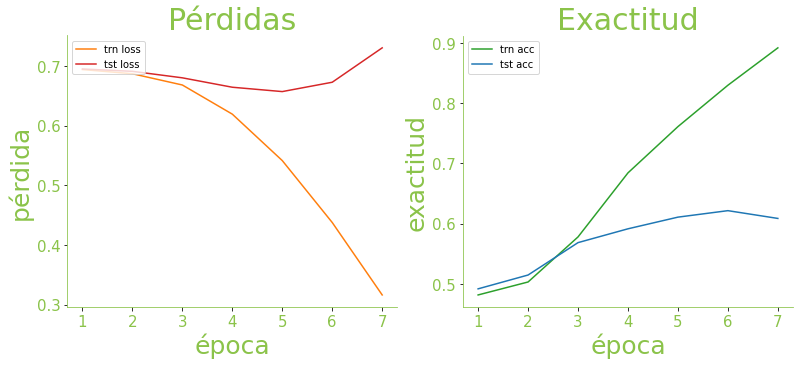

In [52]:
plot(loss_hist, acc_hist, name = "cnn3_3conv_g", epoch = 7)

[Volver al índice](#Índice)